In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
def read_benches(path):
    with open(path, 'r') as f:
        res_text = f.read()
    return res_text.split('###')[1:]

In [3]:
def boxplot(arrs, bench_title, var_titles, xlabel="variant"):
#     fig = plt.figure(figsize =(16, 7))

    # Creating axes instance
#     ax = fig.add_axes([0, 0, 1, 1])
    fig, ax = plt.subplots(figsize=(14, 7))

    # Creating plot
    bp = ax.boxplot(arrs)
    fig.suptitle(bench_title, fontsize=14, fontweight='bold')
    ax.set_ylabel('time in microsecends')
    ax.set_xlabel(xlabel)
    ax.set_xticklabels( var_titles, fontsize=8)
    ax.set_ylim(bottom=0)

    plt.savefig(f"{bench_title.split('.')[0]}_box.pdf")
    plt.show()


In [4]:
def barchart(means, title):
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 7))
    labels = ["w/o other binaryen passes", "w/ other binaryen passes"]
    x = np.arange(len(labels))  # the label locations
    rects1 = ax.bar(x - (1.5 * width), [means[0], means[3]], width, label='No Phi')
    rects2 = ax.bar(x, [means[1], means[4]], width, label='Phi')
    rects3 = ax.bar(x + (1.5*width), [means[2], means[5]], width, label='Phi with call')


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean Execution Time in Microseconds')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    locations = np.sort(np.concatenate([x - (1.5*width), x, x+(1.5*width)]))
    for i, v in enumerate(means):
        ax.text(locations[i] -(.3 * width), v *0.9, str(v), color='white', fontweight='bold')

    fig.tight_layout()
    plt.savefig(f"{title.split('.')[0]}_bar.pdf")
    plt.show()

In [5]:
def analyse_benchmark(txt):
    lines = txt.splitlines()
    bench_title = lines[0].rsplit('/', 1)[-1]
    variants = txt.split('~~~')[1:]
    titles = [variant.splitlines(1)[0][:-3] for variant in variants]
    arrs = [np.array([int(x) for x in variant.splitlines() if x.isnumeric()]) for variant in variants]
    assert len(arrs) == 6
    means = [a.mean() for a in arrs]
    boxplot(arrs, bench_title, titles)
    print(" & ".join((str(m) for m in means)))
    barchart(means, bench_title)
    
    print(f"Phi introduced a slow-down of {(means[1]-means[0])*100/means[0]:.1f}% in average.\n\n")
    
    

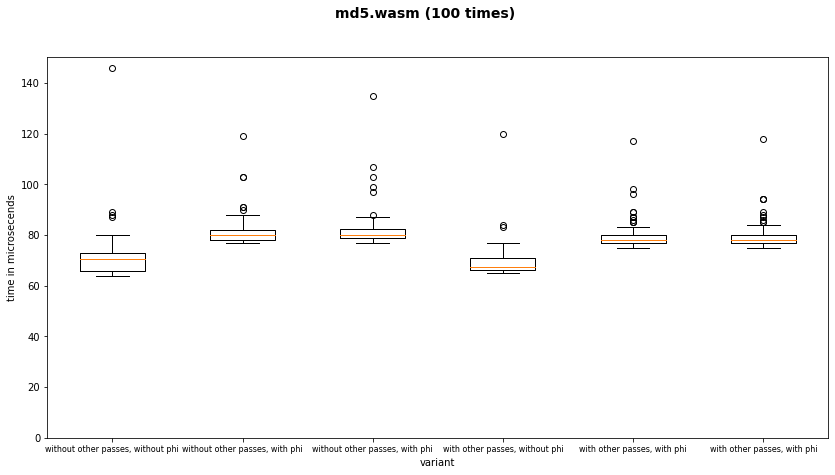

70.9 & 81.06 & 81.89 & 69.63 & 79.75 & 79.46


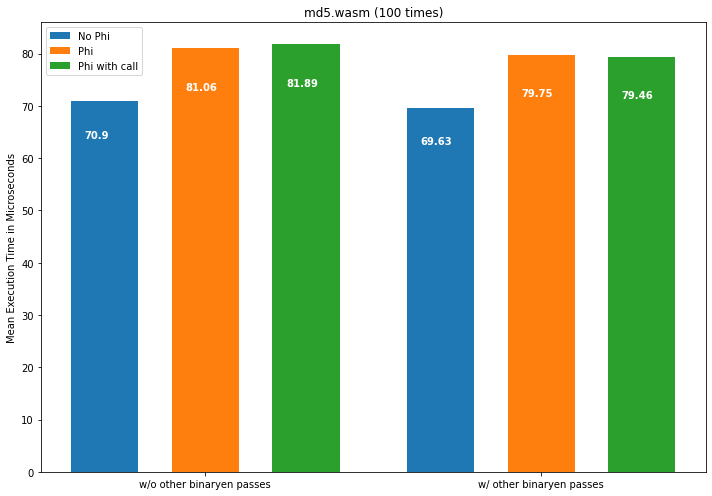

Phi introduced a slow-down of 14.3% in average.




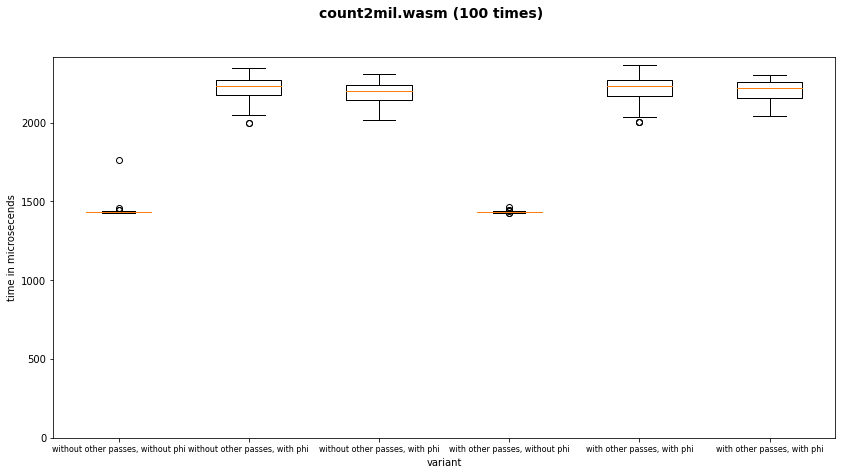

1438.01 & 2216.36 & 2190.41 & 1434.57 & 2216.2 & 2204.26


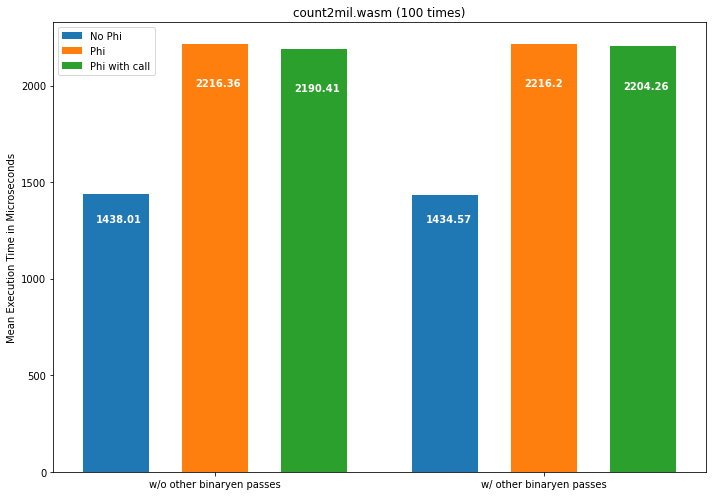

Phi introduced a slow-down of 54.1% in average.




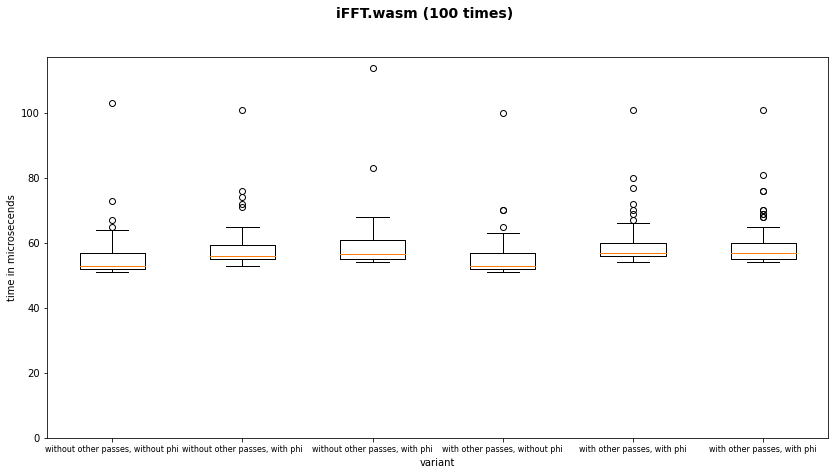

55.56 & 58.07 & 58.76 & 55.35 & 59.18 & 58.92


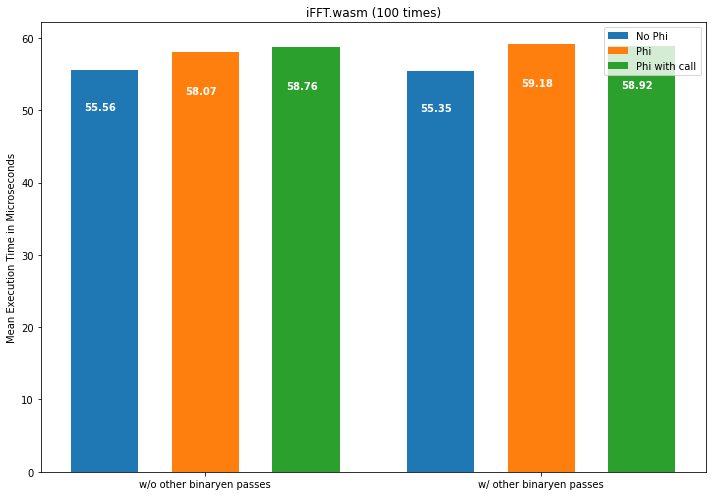

Phi introduced a slow-down of 4.5% in average.




In [6]:
# benches = read_benches('../cmake-build-release/benchmarks/res22-03.txt')
benches = read_benches('../cmake-build-release/benchmarks/benchmarks.txt')
for bench in benches:
    analyse_benchmark(bench)

In [7]:
def read_interval_benches(path):
    with open(path, 'r') as f:
        res_text = f.read()
    return res_text.split('%%%')[1:]


def get_call_nums(lines):
    seen = set()
    seen_add = seen.add
    return [int(re.findall("\d+", line)[0]) for line in lines if line.endswith("times!") and not (line in seen or seen_add(line))]

def line_chart(title, means, costs, freqs, xlabel, xlabels, log_scale=False):
    fig, ax = plt.subplots(figsize=(16, 7))
    ax.plot(means, label="Mean Total Execution Time")
    ax.plot(costs, label="Mean Execution Time of Single Call to Host")
    ax.set_xticks(range(len(means)))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel(xlabel)
    if log_scale:
        ax.set_yscale('log')
        file_name = "line_chart_log.tex"
    else:
        file_name = "line_chart.tex"
    ax.set_ylabel(f'Mean Execution Time in Microseconds{" (Logarithmic Scale)" if log_scale else ""}')
    ax.set_title(title)
    plt.xticks(rotation=45)
    ax.legend()
    plt.savefig(f'interval_{title.split(".")[0]}{"_log" if log_scale else ""}.pdf')
    plt.show()
    

def analyse_intervals_benchmark(txt):
    lines = txt.splitlines()
    get_call_nums(lines)
    bench_title = lines[0].rsplit('/', 1)[-1]
    variants = txt.split('~~~')[1:]
    arrs = [np.array([int(x) for x in variant.splitlines() if x.isnumeric()]) for variant in variants]
    arrs[0] = np.delete(arrs[0], 0) # discard first measurement, as it includes some start-up slowdown.
    means = [a.mean() for a in arrs]
    stds = [a.std() for a in arrs]
    avg_costs = [0]
    freqs = [0]
    percents = [0]
    call_nums = get_call_nums(lines)
    for mean, calls_num in zip(means[1:], call_nums[1:]):
        avg_costs.append((mean - means[0])/calls_num)
        percents.append((mean - means[0])*100/mean)
        freqs.append(1000000 // (mean/calls_num))
    titles = [f"{2}^{i-1}\n({f:.2e})" for i, f in enumerate(freqs)]
    titles[0] = '0'
    xtitle = "Total Number of Calls to Host during Execution (In Paratheses: Number of Calls per Second)"
    boxplot(arrs, bench_title, titles, xtitle)
    line_chart(bench_title, means, avg_costs, freqs, "Total Number of Calls to Host during Execution (In Paratheses: Number of Calls per Second)", titles)
    line_chart(bench_title, means, avg_costs, freqs, "Total Number of Calls to Host during Execution (In Paratheses: Number of Calls per Second)", titles, log_scale=True)
    print("Was the mean cost of a all calls to the host smaller than the standard deviation of that level's measurements?")
    print([f"{i}: {abs(mean - means[0]) < std}" for i, (mean, std) in enumerate(zip(means, stds))])
    
    print("The estimated host call time as percent of whole execution time:")
    for freq, per in zip(freqs, percents):
        print(f"{int(freq)} Hz: {per:.2f}%", end=", ")
    print()


def analyse_intervals(filename):
    interval_benches = read_interval_benches(filename)
    for bench in interval_benches:
        analyse_intervals_benchmark(bench)



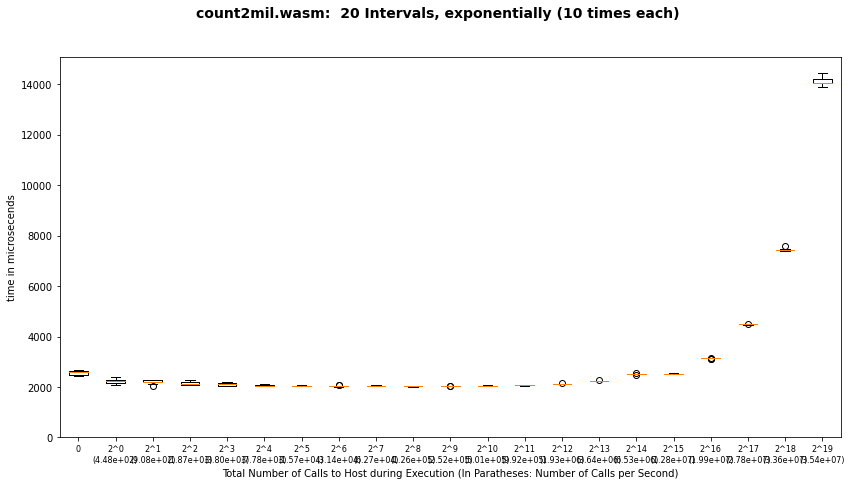

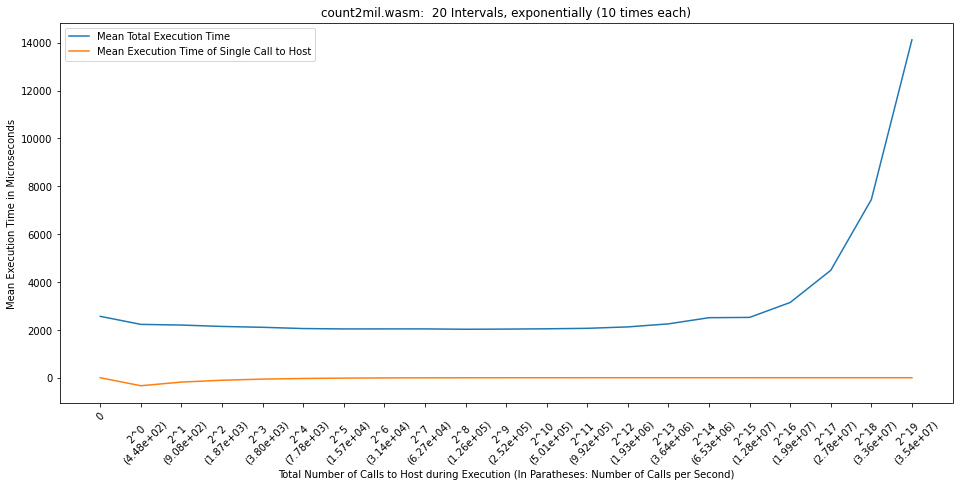

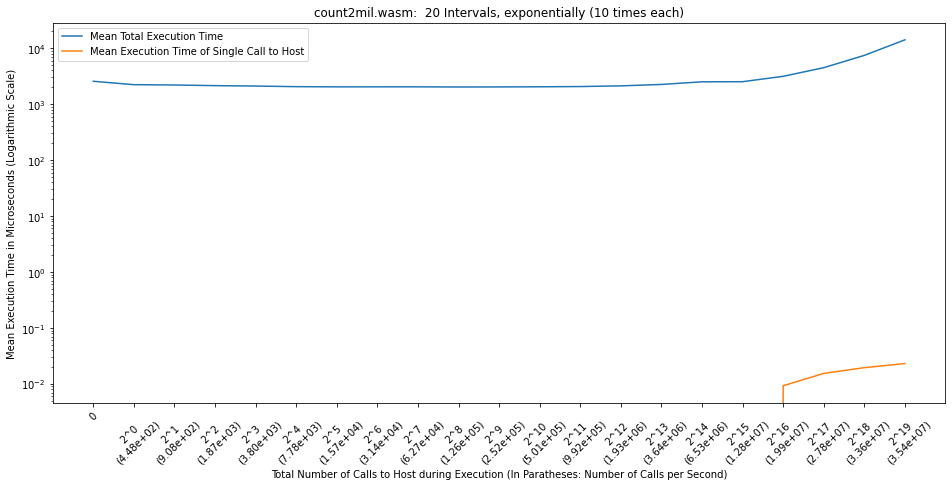

Was the mean cost of a all calls to the host smaller than the standard deviation of that level's measurements?
['0: True', '1: False', '2: False', '3: False', '4: False', '5: False', '6: False', '7: False', '8: False', '9: False', '10: False', '11: False', '12: False', '13: False', '14: False', '15: False', '16: False', '17: False', '18: False', '19: False', '20: False']
The estimated host call time as percent of whole execution time:
0 Hz: 0.00%, 448 Hz: -15.05%, 908 Hz: -16.52%, 1866 Hz: -19.69%, 3797 Hz: -21.74%, 7784 Hz: -24.80%, 15693 Hz: -25.79%, 31366 Hz: -25.71%, 62723 Hz: -25.69%, 126369 Hz: -26.62%, 251906 Hz: -26.20%, 500806 Hz: -25.45%, 992492 Hz: -24.24%, 1929560 Hz: -20.77%, 3641371 Hz: -13.96%, 6534720 Hz: -2.25%, 12795715 Hz: -1.75%, 19875341 Hz: 18.43%, 27845845 Hz: 42.86%, 33575841 Hz: 65.55%, 35404926 Hz: 81.84%, 


In [8]:
analyse_intervals('../cmake-build-release/benchmarks/intervals.txt')